# Identificación de tendencias con trendet y comparación de sentimiento con el comportamiento del mercado con datos de investpy y twipper

**por Álvaro Bartolomé del Canto @ alvarob96 en GitHub**

---
## Introducción

En este informe se presenta el resultado del estudio realizado combinando los paquetes de Python [trendet](https://github.com/alvarob96/trendet) y [twipper](https://github.com/alvarob96/twipper), para la detección de tendencias en series temporales de datos históricos de una acción y para la recuperación de tweets a través de la API de Twitter desde Python, respectivamente.

---
## Caso de Estudio - Endesa

Se utilizará **trendet** para identificar tendencias en la serie temporal del último año de una empresa, en este caso se propone el caso de estudio con **Endesa**, que es una empresa española que opera en los sectores eléctrico y gasístico. Una vez identificadas las tendencias a lo largo de los datos históricos de cierre del último año de ENDESA, se procede a la recuperación de los tweets publicados desde España y en español entre las fechas entre las que se comprende dicha tendencia, a través de la búsqueda en la API Premium de Twitter, a través de **twipper**.

In [1]:
import trendet

In [2]:
(trendet.__author__, trendet.__version__)

('Alvaro Bartolome @ alvarob96 on GitHub', '0.5')

In [3]:
import twipper

In [4]:
(twipper.__author__, twipper.__version__)

('Alvaro Bartolome @ alvarob96 on GitHub', '0.1.3')

Se utilizará la función `identify_all_trends` de **trendet** para identificar todas las tendencias que se dan a lo largo de los datos históricos de **Endesa** en el período comprendido entre 2018 y 2019, siempre que la tendencia dure más de 5 días, es decir, una semana de mercado ya que solo son hábiles los días de lunes a viernes. 

In [72]:
df = trendet.identify_all_trends(equity='bankia',
                                 country='spain',
                                 from_date='01/01/2018',
                                 to_date='01/01/2019',
                                 window_size=5)

In [73]:
df.head()

,Open,High,Low,Close,Volume,Currency,Up Trend,Down Trend
Date,,,,,,,,
2018-01-02,4.000,4.053,3.990,4.041,3900000,EUR,A,NaN
2018-01-03,4.057,4.064,4.038,4.051,3020000,EUR,A,NaN
2018-01-04,4.074,4.133,4.064,4.110,5180000,EUR,A,NaN
2018-01-05,4.125,4.146,4.122,4.132,4690000,EUR,A,NaN
2018-01-08,4.145,4.168,4.095,4.104,3350000,EUR,A,NaN


Una vez se han identificado las tendencias y se dispone del `pandas.DataFrame` resultante del cálculo de dichas tendencias, se procede a la identificación de las mismas sobre una gráfica de una serie temporal. De este modo, se podrán visualizar las tendencias identificadas para determinar cual o cuales serán las tendencias a estudiar junto con los datos recuperados de Twitter.

In [74]:
up_trends = df['Up Trend'].dropna().unique().tolist()

In [75]:
down_trends = df['Down Trend'].dropna().unique().tolist()

In [76]:
df.reset_index(inplace=True)

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

Anotar que para la visualización se hará uso del estilo creado por [@Dih5](https://github.com/Dih5) llamado [paper-themes](https://github.com/Dih5/paper-themes) para la visualización de gráficas con [matplotlib](https://matplotlib.org/), pensado para publicaciones científicas.

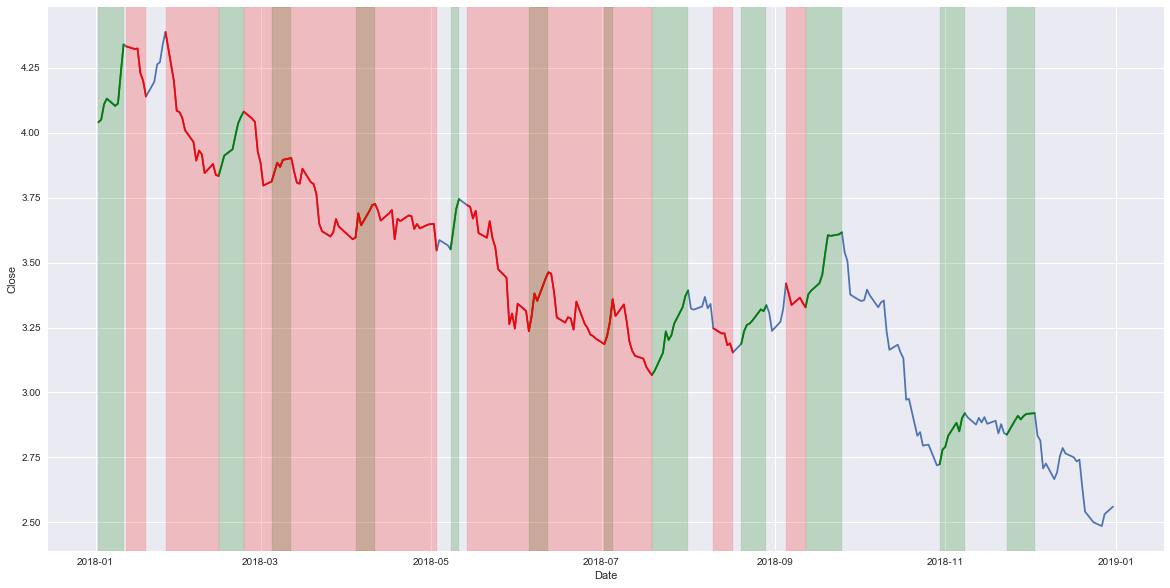

In [78]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(20, 10))

    ax = sns.lineplot(x=df['Date'], y=df['Close'])

    labels = df['Up Trend'].dropna().unique().tolist()

    for label in labels:
        sns.lineplot(x=df[df['Up Trend'] == label]['Date'],
                     y=df[df['Up Trend'] == label]['Close'],
                     color='green')

        ax.axvspan(df[df['Up Trend'] == label]['Date'].iloc[0],
                   df[df['Up Trend'] == label]['Date'].iloc[-1],
                   alpha=0.2,
                   color='green')

    labels = df['Down Trend'].dropna().unique().tolist()

    for label in labels:
        sns.lineplot(x=df[df['Down Trend'] == label]['Date'],
                     y=df[df['Down Trend'] == label]['Close'],
                     color='red')

        ax.axvspan(df[df['Down Trend'] == label]['Date'].iloc[0],
                   df[df['Down Trend'] == label]['Date'].iloc[-1],
                   alpha=0.2,
                   color='red')

    plt.show()

Tras mostrar las tendencias en forma de gráfica e identificar que las tendencias predominantes son las bajistas, se procederá a la identificación de los intervalos de cada una de ellas con el fin de ver cúal ha tenido más impacto sobre el valor en bolsa de Endesa, para así poder llevar dicha franja temporal a estudio con los datos de Twitter de Endesa.

In [13]:
for down_trend in down_trends:
    print(df[df['Down Trend'] == down_trend]['Date'].tolist()[0].strftime('%Y%m%d%H%S'),
          df[df['Down Trend'] == down_trend]['Date'].tolist()[-1].strftime('%Y%m%d%H%S'))
    print(df[df['Down Trend'] == down_trend]['Close'].tolist()[0],
          df[df['Down Trend'] == down_trend]['Close'].tolist()[-1])

201802010000 201802090000
17.97 16.6
201803190000 201803230000
17.39 17.115
201805230000 201805310000
19.95 18.845
201807180000 201807240000
19.87 19.37


La tendencia a analizar es la que corresponde al periodo comprendido entre: **'201802010000'** y **'201802090000'**. En este caso es una tendencia bajista, en la que el mercado cambia de manera abrupta de una forma muy negativa, bajando su valor en bolsa de '17.97' a '16.6', en un periodo de tan solo 7 días.

De este modo, ahora a partir de la información de Twitter extraida a través de [twipper](https://github.com/alvarob96/twipper/) se pretende analizar el impacto de la opinión volcada en Twitter por los usuarios analizando su sentimiento, con el fin de determinar si afecta de un modo negativo al comportamiento del mercado y, así de algún modo, condiciona el mismo. Lo cual implica la utilización del modelo, creado previamente, para el análisis de sentimientos en positivo, negativo o neutral de una colección de tweets de entrada dada.

Destacar que para la recuperación de tweets históricos en una franja temporal determinada se requiere el uso de la API Premium de Twitter, ya que la versión gratuita tan solo da acceso a datos históricos de los últimos 7 días, con lo que no es viable el uso de la versión gratuita de la misma.

In [14]:
cred = twipper.Twipper(consumer_key='Si1dJus1cp3YefEzGsnbLh37u',
                       consumer_secret='vDoaKZ49J2IfCO9BeM8hWONPd0AF00wxfQ16ilhKlEKz66pqZv',
                       access_token='894988499526590464-axe4Lj1pATPMLpIrxpAdw38HnOodYaf',
                       access_token_secret='4aNUPWEdIoSz0E2mZe9ywYxyDL8orWWufLgEvaOrhHfWt')

In [15]:
cred.plan = 'fullarchive'
cred.label = 'research'

Se hará uso también de una funcionalidad adicional implementada por **twipper**, que consiste en el formateo de queries del formato especificado y estandarizado por **twipper**, al formato de Twitter, que es distinto para las búsquedas batch o en streaming. Por tanto, al no tener un formato unificado, hace que la utilidad implementada por **twipper** sea de gran utilidad.

In [16]:
from twipper.utils import standard_query

In [17]:
query = standard_query('endesa OR endesa AND electricidad OR endesa AND gas')

In [20]:
query

'endesa OR endesa electricidad OR endesa gas'

In [21]:
from twipper.premium import search_tweets

In [22]:
tweets = search_tweets(access=cred,
                       query=query,
                       page_count=2,
                       from_date='201802010000',
                       to_date='201802090000',
                       language='es',
                       filter_retweets=False)

In [23]:
len(tweets)

200

In [33]:
unseen_tweets = list()

In [34]:
for tweet in tweets:
    if 'retweeted_status' in tweet:
        continue
    elif 'extended_tweet' in tweet:
        unseen_tweets.append(tweet['extended_tweet']['full_text'])
    else:
        unseen_tweets.append(tweet['text'])

In [35]:
len(unseen_tweets)

53

In [45]:
unseen_tweets[:5]

['https://t.co/6knegziosA\n\nDarse de baja de Endesa',
 'Endesa y Gas Natural Fenosa realizan la primera transacción de energía con tecnología… https://t.co/fJnErfbt7K',
 'Uno de los retos de la #empresa saludable según @miriamfillesa @endesa #JCorrSalud https://t.co/OhMJ3Uus4v',
 'Anna Montañana hace historia al convertirse en entrenadora ayudante de un equipo de la ACB https://t.co/gR0xjlGINW vía @publico_es',
 'Anna Montañana, al Fuenla: primera mujer en un cuerpo técnico ACB https://t.co/1ar8RZHLZu']

Ahora, dado que ya se ha explicado en el informe de [twipper-sentiment](https://github.com/alvarob96/tcue/blob/master/docs/tcue_sentiment.pdf), se procederá a la implementación del sistema de preparación de los datos de cara a aplicar el modelo creado en dicho informe. Por tanto, antes de proceder con este informe, se recomienda que se consulte antes el anterior informe.

In [37]:
def get_stopwords():
    stopwords_list = list()

    with open('resources/stopwords-es.txt', 'rt', encoding='utf-8') as stopwords:
        for stopword in stopwords.readlines():
            stopwords_list.append(stopword.strip())

        stopwords.close()
        
    return stopwords_list

In [38]:
import re

In [39]:
def tokenizer(tweet, stopwords_list):
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    html_pattern = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    spaces_pattern = re.compile('[ ]{2,}')
    
    result = url_pattern.sub('', tweet)
    result = html_pattern.sub('', result)
    result = spaces_pattern.sub('', result)
    result = re.findall('\w+', result)
    
    result = ' '.join([word.lower() for word in result if word.lower() not in stopwords_list])
    
    return result

In [41]:
stopwords = get_stopwords()

In [42]:
tokenized_tweets = [tokenizer(unseen_tweet, stopwords) for unseen_tweet in unseen_tweets]

In [44]:
tokenized_tweets[:5]

['darse baja endesa',
 'endesa gas natural fenosa realizan transacción energía tecnología',
 'retos empresa saludable miriamfillesa endesa jcorrsalud',
 'anna montañana historia convertirse entrenadora ayudante equipo acbvía publico_es',
 'anna montañana fuenla mujer cuerpo técnico acb']

Para proceder con la clasificación de tweets en sentimientos, en este caso, para tweets nunca vistos por el modelo, se requerirá de la carga tanto del vectorizador **TfidfVectorizer**, como del propio modelo de análisis de sentimientos **RandomForestClassifier**, es decir, de `resources/tfidf.pickle` y de `resources/sentiment_model.pickle`, respectivamente.

In [50]:
import pickle

In [51]:
with open('resources/tfidf.pickle', 'rb') as file_:
    tfidf = pickle.load(file_)

In [52]:
with open('resources/sentiment_model.pickle', 'rb') as file_:
    sentiment_model = pickle.load(file_)

Una vez cargados, se vectorizarán los tweets tokenizados ya que es la entrada requerida por el modelo, que este a su vez clasificará cada uno de los tweets introducidos en una de las categorías previamente mapeadas de la forma:

In [66]:
sentiment_codes = {
    -1: 'negative',
    0: 'neutral',
    1: 'positive',
}

In [54]:
unseen_features = tfidf.transform(tokenized_tweets).toarray()

In [56]:
unseen_prediction = sentiment_model.predict(unseen_features)

Ahora se procede a la creación de un `pandas.DataFrame` cuyo objetivo es mostrar de una forma más clara el resultado del análisis de sentimiento realizado sobre los tweets publicados entre 01/02/2018 y 09/02/2018.

In [57]:
import pandas as pd

In [62]:
df = pd.DataFrame({
    'tweets': unseen_tweets,
    'tokenized_tweets': tokenized_tweets,
    'sentiment': unseen_prediction
})

In [64]:
df.head()

,tweets,tokenized_tweets,sentiment
0,https://t.co/6knegziosA\n\nDarse de baja de En...,darse baja endesa,0
1,Endesa y Gas Natural Fenosa realizan la primer...,endesa gas natural fenosa realizan transacción...,0
2,Uno de los retos de la #empresa saludable segú...,retos empresa saludable miriamfillesa endesa j...,0
3,Anna Montañana hace historia al convertirse en...,anna montañana historia convertirse entrenador...,0
4,"Anna Montañana, al Fuenla: primera mujer en un...",anna montañana fuenla mujer cuerpo técnico acb,0


In [67]:
df = df.replace({'sentiment': sentiment_codes})

In [68]:
df.head()

,tweets,tokenized_tweets,sentiment
0,https://t.co/6knegziosA\n\nDarse de baja de En...,darse baja endesa,neutral
1,Endesa y Gas Natural Fenosa realizan la primer...,endesa gas natural fenosa realizan transacción...,neutral
2,Uno de los retos de la #empresa saludable segú...,retos empresa saludable miriamfillesa endesa j...,neutral
3,Anna Montañana hace historia al convertirse en...,anna montañana historia convertirse entrenador...,neutral
4,"Anna Montañana, al Fuenla: primera mujer en un...",anna montañana fuenla mujer cuerpo técnico acb,neutral


Dado que como se ha explicado previamente el dataset de tweets clasificados de forma manual no es aún del todo completo debido a la gran cantidad de tweets neutrales que hay en Twitter, se determina que para poder establecer la correlación o no entre la tendencia bajista del mercado y el análisis de sentimiento de Twitter, se eliminarán o no se tendrán en cuenta los tweets neutrales.

In [69]:
df = df.drop(df[df['sentiment'] == 'neutral'].index)

In [71]:
df

,tweets,tokenized_tweets,sentiment
10,@ETSIngenieria @Endesa @unisevilla @CienciaUS ...,etsingenieria endesa unisevilla cienciaus cons...,positive
17,Las cosillas que me encuentro trabajando en En...,cosillas encuentro trabajando endesa,positive
19,"🏀♀️Felicitats a Anna Montañana, primera dona a...",felicitats anna montañana dona formar part equ...,positive
20,@ASAJASEVILLA @fibesevilla @PhilHoganEU @mapam...,asajasevilla fibesevilla philhoganeu mapamagob...,positive
21,"Gracias a @Endesa y sus averías nocturnas, est...",gracias endesa averías nocturnas semana ido ca...,positive
44,Enhorabuena @AnnaMontanana Te lo mereces. #Gra...,enhorabuena annamontanana mereces granentrenad...,positive
51,"SE ACERCA EL REGRESO DEL ""TITÁN""\n\nYa habría ...",acerca regreso titán fecha gustavo ayón vuelva...,negative


Como se puede observar, el resultado del estudio no es el esperado, dado que tan solo hay un tweet negativo de entre los tweets no neutrales analizados, lo cual se debe a que Endesa, al ser la empresa patrocinadora de la Liga Endesa de Baloncesto en España, coincide con que los tweets recuperados entre dichas fechas aluden a la celebración de un triunfo de Anna Montaña, que fue una jugadora de baloncesto y es entrenadora española de baloncesto.

---
## Conclusiones

Tal y como se ha podido observar, este caso de estudio no ha sido exitoso debido a que es díficil determinar el comportamiento de una empresa en bolsa, cuando el nombre de la misma empresa no alude directamente a la empresa sino a productos de esta. Con esto se buscará determinar en un futuro el como discernir entre tweets que pueden afectar o no a la empresa de tweets que sí, de modo que se pueda contrastar dicha información con las noticias, sucesos, etc.

El NLP en español y, más en concreto, el análisis de sentimiento en opinión en español es un campo de la Inteligencia Artificial con un largo camino e investigación por delante. El hecho de que no esté tan desarrollado se debe a que en el NLP únicamente, o al menos principalmente, se desarrollan y crean tanto soluciones como datasets en inglés, con lo que hace del NLP en español algo más tedioso.

Adicionalmente, a modo de "Trabajo Futuro", se propone el uso de **Wikipedia** para recuperar la página de Endesa, de modo que las keywords de la búsqueda en Twitter sean más refinadas y aludan no solo a la propia empresa, sino también al sector en el que opera, o a las características del mismo.

---
## Licencia

MIT License

Copyright (c) 2019 Álvaro Bartolomé del Canto

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---
## Autor

**Álvaro Bartolomé del Canto, 2018-2019**